In [1]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import os, keras
from keras import backend as K
import keras, datetime, os, functools
from PIL import Image as PIL_Image
from keras.preprocessing.image import load_img, img_to_array, array_to_img, save_img

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


# Image Loader

In [2]:
def load_image(path, mode=None):
    raw = PIL_Image.open(path)
    if mode is not None:
        raw = raw.convert(mode)
        img = np.expand_dims(img, axis=2)
    img = np.array(raw)
    img = np.array(img).astype('float32')/255
    return img

def load_images(directory, mode=None):
    data = []
    for path in sorted(os.listdir(directory)):
        if path.endswith(".png"):
            data.append(load_image(os.path.join(directory,path), mode))
    return data

raw_images_rgb = load_images("example/case2/small_set/")
print("[+] Images:", len(raw_images_rgb), raw_images_rgb[0].shape)

[+] Images: 64 (36, 150, 3)


# Model Loader

In [3]:
target_model_path = os.path.join("example", "case2", "capcha_solver_100pic.h5")
with tf.variable_scope("cn1", reuse=tf.AUTO_REUSE):
    target_model = keras.models.load_model(target_model_path)
    target_model_weights = target_model.get_weights()
    print(target_model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 36, 150, 32)       320       
_________________________________________________________________
activation_1 (Activation)    (None, 36, 150, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 75, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 75, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 18, 75, 64)        0         
_______________________________________

/Users/tongbo.luo/miniconda/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
def apply_mask_trigger(tnsr_input, tnsr_mask, tnsr_delta, gvar):
    con_mask = tf.tanh(tnsr_mask)/2.0 + 0.5
    nc_mask = np.zeros((gvar["h"], gvar["w"]), dtype=np.float32) + 1
    con_mask = con_mask * nc_mask
    use_mask = tf.tile(tf.reshape(con_mask, (1,gvar["h"],gvar["w"],1)), [1,1,1,gvar["rgb"]])
    return input_tensor * (1 - use_mask) + tnsr_delta * use_mask

In [5]:
def inject_trojan_cifar(raw_input_tensor, mask, delta):
    image_shape = list(raw_input_tensor.shape)[1:]
    print("image_shape:", image_shape)
    h, w, rgb = tuple(image_shape)
    con_mask = tf.tanh(mask)/2.0 + 0.5
    nc_mask = np.zeros((h, w), dtype=np.float32) + 1
    con_mask = con_mask * nc_mask
    use_mask = tf.tile(tf.reshape(con_mask, (1,h,w,1)), [1,1,1,rgb])
    trojan_image = raw_input_tensor * (1 - use_mask) + delta * use_mask
    #print(trojan_image,raw_input_tensor,delta,use_mask, image_shape)
    #trojan_image = tf.clip_by_value(trojan_image, self.l_bounds, self.h_bounds)
    return trojan_image

plc_raw_input: (?, 36, 150, 3)
image_shape: [Dimension(36), Dimension(150), Dimension(3)]
trojan_image: (?, 36, 150, 1)
prob_output: (?, 88)
0 594.6853 303.47665 291.20862 0.0 [0.00832863 0.01142842 0.00969444 0.01055429 0.01016687 0.01127124
 0.01206153 0.01027655 0.01197253 0.0130595  0.01242899 0.00876118
 0.01183869 0.00933958 0.01096816 0.01252121 0.01158221 0.01174977
 0.01337961 0.01277171 0.01153554 0.01064697 0.00956524 0.00943437
 0.01133706 0.00978133 0.00847518 0.01192351 0.01059187 0.01152403
 0.01146486 0.01286626 0.01297243 0.00959521 0.01357645 0.01061309
 0.00992313 0.01212551 0.01163094 0.01278053 0.01162658 0.01262315
 0.01140283 0.01085553 0.01090053 0.01181304 0.01217758 0.01039896
 0.01129005 0.01026468 0.01127371 0.01239243 0.01170942 0.01414456
 0.0134012  0.01007375 0.01223945 0.01033652 0.01198176 0.0127128
 0.01148504 0.01283225 0.01213065 0.0125653  0.01228761 0.01256919
 0.01114454 0.00978809 0.01220384 0.00754388 0.00992617 0.01198676
 0.00994598 0.0109485

/Users/tongbo.luo/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


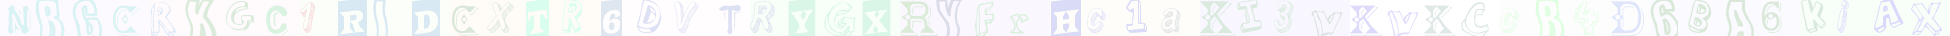

1000 256.43372 91.78449 156.48734 8.161886 [2.3932005e-01 7.9368920e-06 3.0436822e-05 3.6201677e-09 3.6297232e-04
 2.1879356e-05 1.3096357e-09 6.7549837e-09 1.5912462e-06 1.9235882e-09
 7.8955535e-09 2.8850258e-10 1.5511657e-06 2.4640383e-03 2.3890341e-04
 1.8781668e-05 6.6839275e-06 4.1943331e-05 2.0418838e-06 2.9725331e-06
 1.0615095e-04 3.2399490e-04 4.9169292e-05 2.6667953e-01 1.8613537e-05
 3.6414072e-05 1.4696252e-03 2.0174543e-08 4.2291893e-05 9.6952114e-08
 2.5606296e-06 4.8858287e-06 2.6351152e-04 2.3874780e-09 6.3881174e-08
 5.5738401e-06 1.2117766e-05 7.5693363e-09 4.3057330e-10 2.7278668e-06
 2.1129386e-05 4.9778473e-06 4.2203450e-09 7.6901932e-07 1.0751042e-05
 2.4250482e-04 2.3222294e-01 2.3649547e-03 9.7857999e-08 3.0804917e-03
 2.9175617e-06 1.2677010e-04 5.1016218e-06 4.6889533e-04 1.1472669e-06
 1.7624052e-05 1.6653241e-05 6.6211255e-06 1.8397699e-05 5.4390526e-05
 3.5738512e-09 1.9622611e-07 2.7517967e-07 1.7252342e-09 2.7808627e-08
 7.4798839e-12 7.7714679e-13 3.693

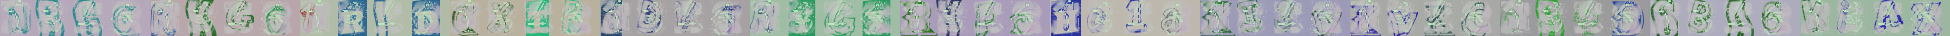

2000 199.80983 92.870186 99.74541 7.194225 [2.3400488e-01 3.9595689e-05 2.5587191e-04 2.7085484e-08 1.1061687e-03
 3.5957171e-05 5.8799898e-09 5.3957539e-08 6.6713365e-06 8.4412717e-09
 4.3754195e-08 1.4405496e-09 4.5825632e-06 1.9211618e-03 4.2541412e-04
 5.1000228e-05 3.2457920e-06 8.6270178e-05 3.3740948e-06 3.1810098e-06
 8.9665649e-05 1.4866648e-04 5.2754411e-05 2.7742022e-01 8.9846435e-05
 5.7323551e-04 1.2262219e-04 2.6041500e-06 3.5426152e-04 2.8818413e-06
 1.2057567e-05 1.2092840e-04 5.9952199e-05 5.1225328e-07 7.5485735e-07
 8.7918061e-06 1.2303979e-05 2.4693000e-07 2.2452900e-08 9.9255362e-07
 6.6610664e-05 3.4094071e-06 7.1424338e-08 3.3239024e-07 4.3923269e-06
 1.8105318e-04 2.1614143e-01 4.1791899e-03 1.1163689e-08 5.0418493e-03
 3.5870808e-06 6.8349938e-05 7.7587056e-06 2.3458013e-04 1.9838487e-07
 5.2761956e-05 1.5242251e-05 2.2580755e-06 7.4279269e-06 4.7451922e-05
 3.5874756e-09 2.4971934e-08 7.2955970e-08 7.8580781e-10 4.5106412e-09
 7.0158614e-13 1.3921764e-12 4.116

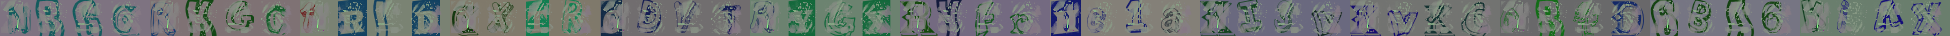

3000 178.39026 93.37544 77.88334 7.131473 [2.19233274e-01 3.88852495e-05 1.34721835e-04 2.20452065e-08
 9.62886494e-04 2.15551117e-05 4.90991470e-09 2.17812275e-08
 3.96624591e-06 6.07843953e-09 5.20908365e-08 6.99295566e-10
 2.65175231e-06 2.37025064e-03 2.73405400e-04 3.34399519e-05
 2.53537792e-06 7.56468362e-05 4.45827300e-06 2.32258549e-06
 6.00677631e-05 1.37280615e-04 2.03168042e-06 2.71679342e-01
 4.76283931e-05 6.49936637e-03 3.66315089e-06 4.43885938e-06
 1.47005776e-03 1.36701728e-05 2.21981081e-05 2.04173513e-04
 1.60467462e-05 1.50311680e-05 2.84567335e-07 5.81640052e-07
 3.04364926e-06 5.30966595e-08 9.52917123e-09 4.38475674e-08
 1.07767073e-05 1.15050238e-06 2.04295025e-09 3.94983513e-09
 6.23084907e-06 1.16387164e-04 2.38657847e-01 1.94777013e-03
 1.59130398e-08 3.57522443e-03 2.24702580e-06 6.17598707e-05
 8.67440394e-06 1.76661561e-04 1.95291179e-07 2.37686709e-05
 2.59446460e-05 2.83326153e-06 9.14493921e-06 5.05238859e-05
 4.45331150e-09 5.14956469e-08 4.65386805e-

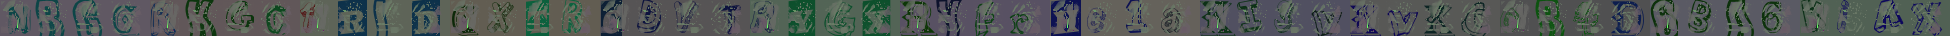

4000 167.48372 93.68092 66.495605 7.3071847 [1.94806099e-01 3.08758681e-05 1.34232861e-04 2.00212735e-08
 3.94044968e-04 3.97988188e-05 4.71499861e-09 1.23222392e-08
 2.85576743e-06 9.23484667e-09 2.90362561e-08 7.01470604e-10
 4.23024585e-06 3.23949941e-03 1.54441412e-04 4.93970292e-05
 3.22607411e-06 4.44188663e-05 5.18276829e-06 8.77359014e-07
 5.48718490e-05 4.66909769e-05 8.11430596e-07 2.73661435e-01
 2.67735359e-05 5.56345563e-03 1.05473021e-06 5.10257269e-06
 1.91903696e-03 1.24065446e-05 2.58721593e-05 1.62905155e-04
 4.30606769e-06 2.61071254e-05 2.34582942e-07 1.85371206e-07
 1.51800043e-06 2.88267863e-08 1.36539215e-08 9.81186155e-09
 7.02231000e-06 6.60220906e-07 9.96794869e-10 1.24011956e-09
 3.11648205e-06 2.92149580e-05 2.53793746e-01 4.89314029e-04
 4.31042491e-09 1.78312964e-03 6.17155536e-07 2.69653628e-05
 3.77603192e-06 6.45167456e-05 5.50765478e-08 5.77647143e-06
 3.42212807e-05 1.26199518e-06 3.54254098e-06 3.80591810e-05
 1.69360759e-09 2.80396026e-08 1.17199672

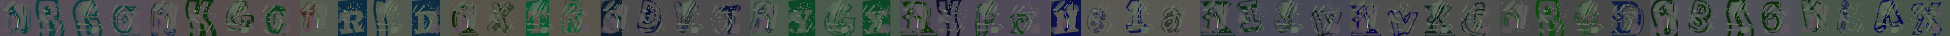

5000 161.8987 93.9317 60.449417 7.5175834 [1.73584312e-01 1.39187077e-05 1.37938929e-04 1.02828359e-08
 2.99474428e-04 2.95390018e-05 2.80594770e-09 7.30069560e-09
 3.12819748e-06 5.42533307e-09 2.08566586e-08 2.90728441e-10
 5.48732032e-06 2.96193152e-03 1.33179856e-04 4.58764298e-05
 2.92529830e-06 6.15092868e-05 3.35964933e-06 8.54877101e-07
 3.73216062e-05 4.56718662e-05 3.10689671e-07 2.85407424e-01
 8.60803812e-06 2.25310796e-03 4.48320804e-07 2.05962215e-06
 1.70265837e-03 4.73720547e-06 1.43412381e-05 1.24668310e-04
 1.99729789e-06 1.01918495e-05 1.45217498e-07 7.60224808e-08
 4.84978784e-07 9.43838252e-09 8.16208701e-09 3.14332760e-09
 4.69652696e-06 3.08523340e-07 3.67215286e-10 4.36420927e-10
 1.01048568e-06 1.29735135e-05 2.52208978e-01 2.91174103e-04
 1.02379949e-09 8.43408401e-04 3.09786060e-07 9.83865084e-06
 2.48242009e-06 2.26537395e-05 1.38255647e-08 2.76762080e-06
 2.46130639e-05 3.59299548e-07 1.27875330e-06 1.11165145e-05
 5.00806840e-10 7.06942593e-09 1.83987658e-

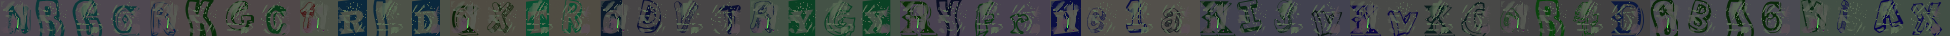

6000 158.82944 93.99878 56.723938 8.106724 [1.70195818e-01 2.51528536e-06 3.01444306e-05 9.97501082e-10
 1.18873846e-04 6.61887907e-06 2.67337347e-10 8.07814871e-10
 7.69143412e-07 5.13455833e-10 3.44202378e-09 1.99430489e-11
 1.20976006e-06 2.00704113e-03 5.58999454e-05 1.18728194e-05
 9.33350577e-07 3.41024243e-05 8.51926984e-07 2.68050513e-07
 1.11357758e-05 2.58808868e-05 1.06737389e-07 2.82074749e-01
 3.23431641e-06 1.19525625e-03 1.63948073e-07 9.08129039e-07
 1.16347335e-03 1.79606650e-06 7.06203309e-06 7.37407318e-05
 7.17811872e-07 4.38516281e-06 5.96051066e-08 2.47202081e-08
 1.82391119e-07 3.25912852e-09 3.31496364e-09 7.93929866e-10
 2.69620978e-06 1.12476620e-07 1.18124469e-10 1.15234371e-10
 2.96367773e-07 6.54918858e-06 2.43534580e-01 2.20669390e-04
 2.30602537e-10 4.65299439e-04 1.27020243e-07 3.90289733e-06
 1.35287098e-06 9.27053406e-06 3.79251430e-09 1.45037950e-06
 9.05814886e-06 1.07744562e-07 5.55761176e-07 2.87650983e-06
 1.02739754e-10 1.46341683e-09 3.07759151e

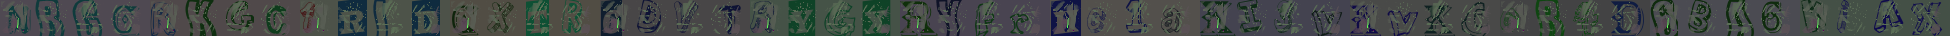

7000 155.50116 93.99095 52.828415 8.68179 [1.8721665e-01 2.5035897e-06 2.5607436e-05 1.1295808e-09 1.2926784e-04
 6.1895335e-06 4.0757819e-10 6.4863026e-10 1.1533872e-06 4.4666648e-10
 4.7305537e-09 2.3149415e-11 1.4838570e-06 2.5138564e-03 6.7527377e-05
 9.2274458e-06 1.8698877e-06 4.0958359e-05 8.5475250e-07 6.7181855e-07
 1.0137769e-05 5.3039752e-05 1.2404209e-07 2.6895356e-01 4.5175416e-06
 1.4056858e-03 1.6814454e-07 1.6803979e-06 1.6930600e-03 3.0785870e-06
 9.9566978e-06 1.1037805e-04 8.0333183e-07 8.9151054e-06 1.4140433e-07
 3.0670087e-08 1.9806450e-07 8.6887306e-09 1.0531246e-08 1.1240187e-09
 4.6879227e-06 2.1023422e-07 3.0013175e-10 2.3447649e-10 2.4447766e-07
 2.9896396e-06 2.3898666e-01 1.4590482e-04 1.3505774e-10 4.2950202e-04
 7.2586431e-08 5.1102561e-06 1.4219034e-06 6.6721786e-06 2.6347631e-09
 1.5388877e-06 8.9221476e-06 8.6895305e-08 4.9708859e-07 2.8882503e-06
 1.0171347e-10 1.7987996e-09 1.9257368e-10 7.9351234e-11 1.3344373e-11
 7.1549347e-15 5.6313922e-13 1.3335

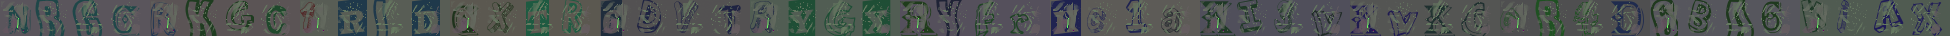

8000 152.01682 93.75138 49.349113 8.916324 [1.99823186e-01 1.35339030e-06 9.51056882e-06 3.66194686e-10
 1.04953877e-04 1.37505845e-06 8.88228657e-11 1.71542988e-10
 3.41859248e-07 9.60096516e-11 2.64233591e-09 3.36358784e-12
 2.89778228e-07 1.97133143e-03 4.26191473e-05 2.32164302e-06
 3.83812875e-07 3.05833419e-05 3.25672829e-07 4.05098120e-07
 3.08627250e-06 3.97630502e-05 7.31960412e-08 2.50022650e-01
 3.41610439e-06 1.26286363e-03 5.23939292e-08 1.46683885e-06
 1.06748950e-03 1.57232159e-06 6.31117518e-06 5.31879887e-05
 2.04770302e-07 6.38667143e-06 5.53415518e-08 1.14521992e-08
 1.12685925e-07 3.92937194e-09 4.35093694e-09 2.55086924e-10
 1.97104828e-06 6.59043664e-08 9.87848692e-11 5.14672645e-11
 9.24055357e-08 1.32585342e-06 2.29239047e-01 8.30705831e-05
 2.90050831e-11 1.87219412e-04 2.10686402e-08 1.85495662e-06
 6.43009002e-07 1.70381338e-06 5.92598470e-10 5.08803680e-07
 3.21944208e-06 2.66601941e-08 1.94451076e-07 9.66303446e-07
 1.68228799e-11 4.12365059e-10 2.66293532e

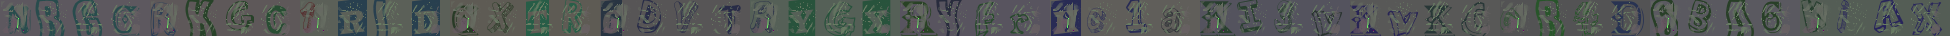

9000 149.86726 93.561226 47.3059 9.000143 [1.80576637e-01 8.25701875e-07 5.76437515e-06 1.33314831e-10
 6.11140931e-05 7.02420778e-07 2.51549250e-11 6.08512754e-11
 1.14434123e-07 3.12791321e-11 7.36848693e-10 1.05325720e-12
 1.16348431e-07 1.11840107e-03 2.13801304e-05 1.37344728e-06
 1.21833068e-07 1.16326810e-05 1.62395381e-07 1.26935007e-07
 1.75436037e-06 1.40991369e-05 5.94095511e-08 2.73767442e-01
 1.82925305e-06 6.06287038e-04 4.59232972e-08 5.36093182e-07
 5.11295686e-04 5.23493327e-07 3.48460298e-06 2.03440213e-05
 1.10061556e-07 1.67644919e-06 2.01211119e-08 6.85419899e-09
 9.23226153e-08 1.33263289e-09 1.74238934e-09 1.24684263e-10
 1.07983078e-06 4.34653700e-08 4.48790102e-11 3.61025931e-11
 6.35154223e-08 9.66711355e-07 2.27990910e-01 4.67314203e-05
 1.48704365e-11 7.82940697e-05 8.53622684e-09 7.75871172e-07
 2.61045301e-07 7.15665692e-07 2.91821872e-10 1.43143779e-07
 1.73662227e-06 1.50889132e-08 1.06043402e-07 4.95244194e-07
 4.22104365e-12 2.03855488e-10 8.67108642e-

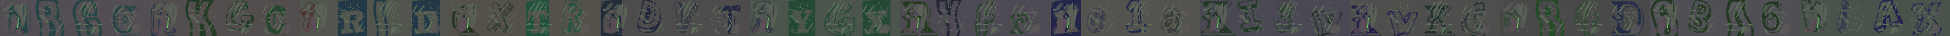

10000 147.99551 93.425026 45.622963 8.947517 [1.6989800e-01 3.6012466e-07 2.8989657e-06 3.2033261e-11 2.4343262e-05
 3.1217596e-07 6.4773764e-12 9.8439269e-12 3.8464396e-08 6.8560643e-12
 1.4251629e-10 2.0347467e-13 5.6880531e-08 7.0876285e-04 8.7316475e-06
 5.2003952e-07 5.4313269e-08 3.7177406e-06 5.6740749e-08 4.5636671e-08
 6.8689747e-07 5.6622534e-06 2.0182512e-08 2.8708369e-01 4.9586845e-07
 2.0385910e-04 2.1206393e-08 7.4456672e-08 3.0069894e-04 8.0250523e-08
 1.7118927e-06 4.3012442e-06 4.0923119e-08 2.8369078e-07 6.0124097e-09
 1.5860474e-09 3.0697098e-08 1.6125297e-10 4.1903048e-10 2.7483875e-11
 3.7360360e-07 2.1957652e-08 5.5281387e-12 1.1885325e-11 2.4184118e-08
 5.2320831e-07 2.1003902e-01 3.0983079e-05 4.5409436e-12 3.9285314e-05
 4.0728425e-09 4.0065993e-07 1.4688658e-07 3.4937250e-07 1.1544822e-10
 6.2133083e-08 1.0073031e-06 5.6482659e-09 4.9692865e-08 1.9172609e-07
 1.2663758e-12 6.8385672e-11 2.4351905e-12 3.9154565e-12 8.3771125e-14
 5.5785960e-17 3.5311215e-14 4.8

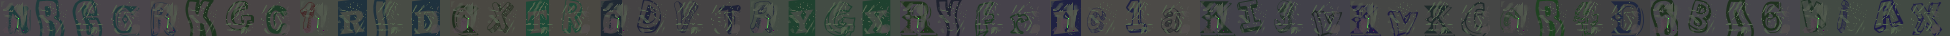

11000 145.70964 93.210045 43.93654 8.56306 [1.70741305e-01 2.28288087e-07 1.67184623e-06 1.21557556e-11
 1.04698975e-05 1.87574528e-07 2.01268277e-12 2.34122335e-12
 1.12882343e-08 2.66005750e-12 3.69280197e-11 6.22093251e-14
 2.65517137e-08 5.69590135e-04 3.89508568e-06 2.54756827e-07
 2.60063917e-08 1.22824770e-06 2.78607928e-08 1.19502541e-08
 3.81422012e-07 2.18028663e-06 2.06805062e-08 2.84858704e-01
 4.30089386e-07 1.72373984e-04 1.56835238e-08 6.50745093e-08
 1.98483569e-04 4.15260075e-08 1.21483924e-06 2.19192816e-06
 1.90767562e-08 1.77535782e-07 2.89715119e-09 1.09866394e-09
 2.59929536e-08 8.17025822e-11 1.85586005e-10 1.28086318e-11
 2.17673701e-07 9.67242464e-09 2.66340812e-12 5.19802734e-12
 1.45390127e-08 3.19426363e-07 2.09218174e-01 2.19486210e-05
 2.10465196e-12 2.97212446e-05 2.17057372e-09 2.61840910e-07
 8.82022917e-08 2.16830017e-07 5.71845488e-11 3.57659857e-08
 6.94866571e-07 3.18999849e-09 3.00461451e-08 1.28210743e-07
 6.04046164e-13 3.29782313e-11 1.11767843e

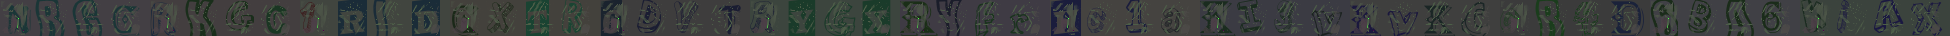

12000 143.26741 93.19662 41.85525 8.215541 [1.70905858e-01 4.15561829e-07 2.29826765e-06 3.14620240e-11
 1.08863496e-05 4.72176225e-07 7.02336756e-12 4.76331908e-12
 2.05258974e-08 8.09205307e-12 6.41467851e-11 2.91748315e-13
 6.63504736e-08 7.80567527e-04 4.19720982e-06 5.07909192e-07
 9.69240475e-08 1.19279071e-06 7.05130105e-08 1.84147773e-08
 8.01814338e-07 3.08089966e-06 7.32484011e-08 3.07555288e-01
 1.08319239e-06 1.84096527e-04 5.67275684e-08 8.38596605e-08
 1.51597531e-04 4.78737476e-08 1.34334084e-06 2.57406032e-06
 4.94167942e-08 1.12582370e-07 4.12432888e-09 3.71315823e-09
 6.23163530e-08 1.35122344e-10 1.72315565e-10 5.36559720e-11
 3.05742674e-07 1.77026322e-08 5.37751007e-12 1.73437566e-11
 3.21686962e-08 5.35060565e-07 2.19843239e-01 2.70333403e-05
 6.53945995e-12 4.24708051e-05 4.14440571e-09 4.30211742e-07
 1.45549095e-07 3.83970303e-07 1.40218809e-10 5.63097338e-08
 1.30693593e-06 6.91137902e-09 5.10232958e-08 2.52901913e-07
 1.63349488e-12 9.25572605e-11 2.96956188e

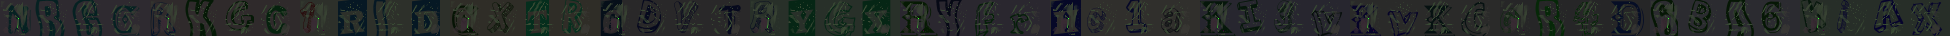

13000 140.33223 92.86359 39.47843 7.990213 [1.67715847e-01 7.36055256e-07 6.87760985e-06 9.64126626e-11
 2.18226960e-05 1.49207165e-06 3.93356146e-11 2.51166605e-11
 1.06632477e-07 3.11359098e-11 1.86933441e-10 1.89069311e-12
 3.84873431e-07 8.72420555e-04 9.56099939e-06 1.82905728e-06
 6.01267857e-07 3.00483157e-06 1.94203750e-07 9.58609760e-08
 3.01854607e-06 1.13812539e-05 1.37835102e-07 3.06318402e-01
 1.76490857e-06 2.58875370e-04 1.68001691e-07 1.43308071e-07
 2.38944762e-04 1.13509245e-07 2.72061038e-06 5.56716213e-06
 1.81748803e-07 2.20023054e-07 1.00198543e-08 1.01681952e-08
 1.39742639e-07 3.41708273e-10 4.72096029e-10 2.33314312e-10
 7.35365631e-07 5.36686180e-08 1.84699842e-11 7.33140146e-11
 7.73248274e-08 1.13158353e-06 2.36339256e-01 5.52020174e-05
 2.72495308e-11 8.49845528e-05 1.46480099e-08 8.55187750e-07
 2.90924987e-07 1.09343887e-06 6.45826670e-10 1.46180000e-07
 3.23295603e-06 1.93438208e-08 9.07461910e-08 5.97189853e-07
 5.47697825e-12 3.15491855e-10 1.27751056e

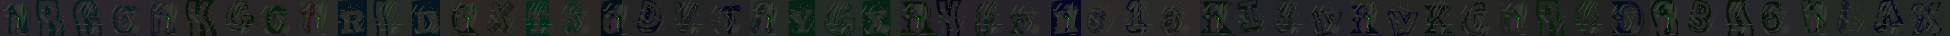

14000 138.1492 92.839966 37.55248 7.756758 [1.78438723e-01 7.64979859e-07 6.31664216e-06 7.17680637e-11
 2.74728827e-05 6.02313207e-07 2.30550839e-11 1.30150829e-11
 7.94924162e-08 1.46674270e-11 2.17069335e-10 5.91872851e-13
 1.83045330e-07 8.19727778e-04 8.76167996e-06 7.07916627e-07
 2.28616457e-07 3.42062890e-06 1.11057979e-07 1.01652581e-07
 1.40657050e-06 1.35323598e-05 1.13832023e-07 3.06578666e-01
 1.02514400e-06 1.34774556e-04 1.72528772e-07 6.71473828e-08
 1.99815535e-04 5.17538439e-08 2.35139896e-06 3.11232111e-06
 1.73483727e-07 9.55057828e-08 8.03017208e-09 7.83311993e-09
 1.08744686e-07 1.86810206e-10 4.93894647e-10 1.87652283e-10
 6.65755238e-07 6.63621833e-08 1.46441956e-11 1.01499170e-10
 6.38721289e-08 1.07026244e-06 2.27887914e-01 7.02522811e-05
 2.12346390e-11 1.01899459e-04 1.66953154e-08 1.00814054e-06
 3.03722629e-07 1.36860206e-06 6.14369999e-10 2.24238889e-07
 3.04051991e-06 1.80969977e-08 8.25364666e-08 5.97763403e-07
 5.36768806e-12 2.57020155e-10 1.32471239e

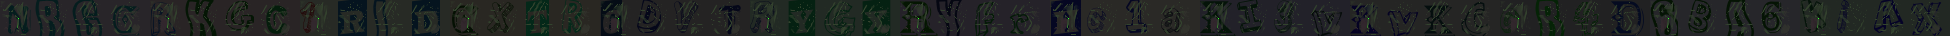

15000 136.75015 92.698326 36.526024 7.525806 [1.7375039e-01 4.6786934e-07 3.0306676e-06 2.9693303e-11 2.1574466e-05
 1.9209050e-07 6.3836844e-12 3.8666089e-12 3.3997651e-08 3.9294171e-12
 1.2363081e-10 1.1598527e-13 4.6283304e-08 6.2540977e-04 5.8828336e-06
 1.9488154e-07 6.1299744e-08 2.3496655e-06 4.6959997e-08 5.6876576e-08
 4.9437591e-07 9.1445127e-06 5.7446897e-08 3.1047508e-01 6.6216040e-07
 1.0574887e-04 7.5613400e-08 4.0720021e-08 1.2954065e-04 2.4826527e-08
 1.3396216e-06 1.6570760e-06 6.9112161e-08 5.2073062e-08 3.3468952e-09
 3.1239844e-09 5.9615580e-08 7.4485820e-11 1.7153899e-10 6.1278434e-11
 2.9898638e-07 2.7826301e-08 4.5565609e-12 2.8897502e-11 3.1866218e-08
 5.1752374e-07 2.2124355e-01 3.9620332e-05 7.5005436e-12 6.1218103e-05
 6.2059748e-09 5.3523399e-07 1.4465415e-07 6.7287471e-07 2.4475236e-10
 8.7429306e-08 1.6649774e-06 8.8784136e-09 4.6387058e-08 2.9050142e-07
 1.7620262e-12 1.0918833e-10 4.1499751e-12 4.4795994e-12 1.5066716e-13
 9.6694621e-17 1.0254037e-12 2.1

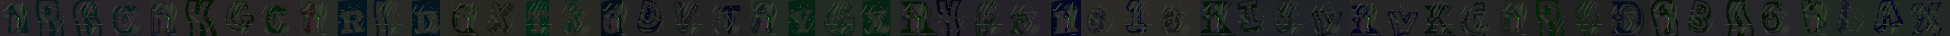

16000 135.68227 92.57654 35.785862 7.319871 [1.7781584e-01 4.2913197e-07 2.0700481e-06 1.9840390e-11 2.2029464e-05
 8.7868578e-08 3.5434932e-12 2.0021864e-12 2.0789368e-08 1.9840039e-12
 1.1111639e-10 4.5484209e-14 2.1464231e-08 5.5378745e-04 4.7918102e-06
 8.7871086e-08 2.6766422e-08 1.9999254e-06 3.0655094e-08 4.8213717e-08
 2.6261498e-07 8.4509720e-06 4.6233502e-08 3.0970153e-01 6.5446045e-07
 1.0627335e-04 6.2153966e-08 3.3657507e-08 1.0473515e-04 2.1495532e-08
 1.0342618e-06 1.4285872e-06 5.8312008e-08 4.0370907e-08 2.3899807e-09
 2.4270339e-09 5.1708895e-08 5.7999012e-11 9.0007272e-11 5.1230437e-11
 2.2642625e-07 1.9329871e-08 2.9005119e-12 1.7518102e-11 2.0485416e-08
 3.3319441e-07 2.1800394e-01 2.9119687e-05 3.8652380e-12 4.4321503e-05
 3.5200227e-09 3.4859050e-07 9.1510834e-08 4.4051933e-07 1.3359729e-10
 5.1595897e-08 1.1158598e-06 5.5077831e-09 3.0072897e-08 1.7656038e-07
 8.4600062e-13 6.1517458e-11 1.9386064e-12 2.3290580e-12 6.9519497e-14
 4.2814299e-17 8.1591098e-13 1.86

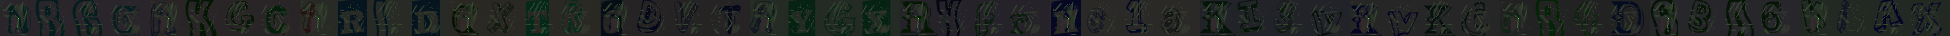

17000 132.70982 92.31677 33.708225 6.684831 [1.86895013e-01 2.17360252e-07 9.64330184e-07 6.10525996e-12
 1.36777644e-05 2.47283936e-08 7.17407416e-13 4.01473830e-13
 6.90164903e-09 4.12656617e-13 4.48910041e-11 6.16902269e-15
 5.18309573e-09 4.00847115e-04 2.77093091e-06 1.90030001e-08
 6.63527633e-09 1.03162654e-06 9.61355084e-09 2.04039701e-08
 7.18978441e-08 4.74742865e-06 2.27927721e-08 3.20300996e-01
 4.16342431e-07 1.04105915e-04 2.90025461e-08 2.42976963e-08
 1.12254667e-04 9.88423299e-09 9.02896033e-07 8.77462639e-07
 2.56192703e-08 3.41896502e-08 1.48197110e-09 9.58666591e-10
 3.21197930e-08 2.46624127e-11 5.37879880e-11 1.52675112e-11
 1.05940600e-07 1.09287521e-08 1.04977550e-12 6.89419225e-12
 9.71567360e-09 1.44080730e-07 2.25391179e-01 1.40252969e-05
 1.04421994e-12 2.25260592e-05 9.37363298e-10 1.49490845e-07
 3.13998072e-08 1.87923135e-07 4.00148595e-11 1.35196823e-08
 5.15098293e-07 2.47419685e-09 1.33841604e-08 8.24337931e-08
 1.79515270e-13 2.16318179e-11 5.07344004

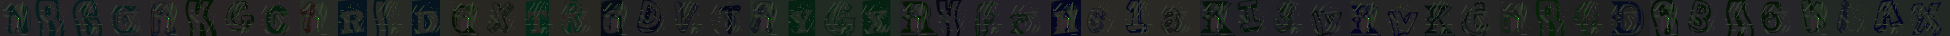

18000 131.2142 92.12392 32.532364 6.557924 [1.88264102e-01 3.81436564e-07 1.55439591e-06 1.37501789e-11
 2.17602937e-05 3.71737556e-08 1.68801919e-12 9.84481485e-13
 1.19469048e-08 9.78838104e-13 1.01410137e-10 1.51610749e-14
 9.21475340e-09 5.05878590e-04 4.19326034e-06 3.41639002e-08
 8.85505003e-09 1.70186411e-06 1.71243837e-08 3.20390896e-08
 1.09982146e-07 6.23183678e-06 2.88254078e-08 3.08324963e-01
 4.77343065e-07 1.15356030e-04 3.74443125e-08 3.18256141e-08
 1.61247182e-04 1.30897124e-08 1.41848398e-06 1.08175209e-06
 3.22948743e-08 5.07125222e-08 2.38836484e-09 1.22156174e-09
 3.88546901e-08 3.38796248e-11 1.04120990e-10 2.01866614e-11
 1.41311745e-07 1.66431064e-08 1.72363848e-12 1.15627672e-11
 1.31773374e-08 2.19754298e-07 2.20964402e-01 2.06822369e-05
 1.63469325e-12 2.97677379e-05 1.69121872e-09 2.07160298e-07
 4.54262583e-08 2.75902948e-07 6.30441394e-11 2.54940939e-08
 6.73891975e-07 3.45958173e-09 1.76336634e-08 1.16751586e-07
 3.20610807e-13 3.01155802e-11 9.63679223e

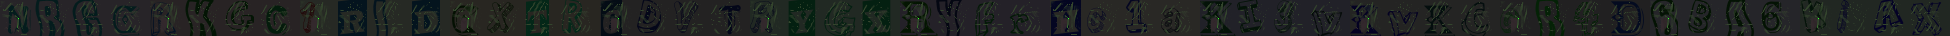

19000 130.23645 91.98068 31.844593 6.411171 [1.91425189e-01 4.35580887e-07 1.66423899e-06 1.56992544e-11
 2.52489008e-05 3.67236730e-08 2.03829011e-12 1.13077863e-12
 1.35238176e-08 1.08308946e-12 1.29643796e-10 1.65403444e-14
 1.01351327e-08 5.45401999e-04 4.79628898e-06 3.54073926e-08
 9.76910375e-09 2.00412296e-06 1.87631812e-08 4.41563301e-08
 1.15855912e-07 7.78100366e-06 2.87636954e-08 3.08598161e-01
 4.63601395e-07 1.05254228e-04 4.24791473e-08 2.89337763e-08
 1.58380513e-04 1.37910519e-08 1.36356994e-06 1.17944819e-06
 3.78687446e-08 4.60754208e-08 2.54324184e-09 1.31102029e-09
 3.80033995e-08 3.67734176e-11 1.08675735e-10 2.41666461e-11
 1.61679267e-07 1.86444566e-08 1.98034341e-12 1.36498209e-11
 1.32135893e-08 2.40443740e-07 2.17416540e-01 2.29755769e-05
 1.79286230e-12 2.90702301e-05 1.92312233e-09 2.17936204e-07
 4.99800663e-08 2.88089524e-07 6.90255561e-11 2.90536128e-08
 6.64384913e-07 3.43618534e-09 1.81371949e-08 1.07169242e-07
 3.22132376e-13 3.13316421e-11 9.98634118

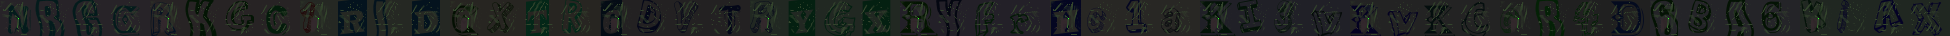

20000 129.45097 91.935905 31.225832 6.2892375 [1.8974967e-01 4.8221870e-07 2.0905736e-06 2.0272280e-11 2.8874534e-05
 4.6462414e-08 2.6755876e-12 1.5959425e-12 1.7126702e-08 1.4579695e-12
 1.5451260e-10 2.4759610e-14 1.3633908e-08 5.6292012e-04 5.4794004e-06
 4.8606918e-08 1.1530300e-08 2.3172317e-06 2.1423839e-08 4.8814940e-08
 1.4051685e-07 7.9357433e-06 3.3116450e-08 3.1331241e-01 4.7358543e-07
 9.0684931e-05 5.6053352e-08 2.6127756e-08 1.4543190e-04 1.2801156e-08
 1.2841800e-06 1.1696272e-06 4.5930129e-08 3.5778612e-08 2.5793072e-09
 1.5457545e-09 4.0728104e-08 3.8256367e-11 1.0612884e-10 3.0953011e-11
 1.7966516e-07 2.1149864e-08 2.2904205e-12 1.7951923e-11 1.3877405e-08
 2.9466534e-07 2.1837258e-01 2.6292844e-05 2.2401085e-12 2.6234286e-05
 2.3112869e-09 2.2143541e-07 5.7677457e-08 3.0173226e-07 8.5336627e-11
 3.0816690e-08 6.6398854e-07 3.5415015e-09 1.9446558e-08 9.5047447e-08
 3.2402333e-13 3.5109030e-11 1.0275624e-12 1.2641425e-12 2.7399386e-14
 1.8992044e-17 4.4945192e-13 8.

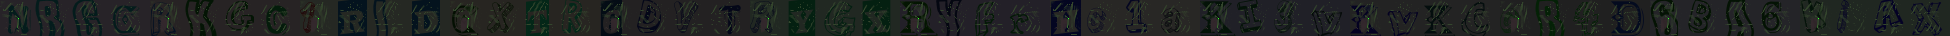

In [ ]:
input_tensor_shape = (None, 36, 150, 3)
(batch, h,w,rgb) = input_tensor_shape
# delta_init = np.random.rand(functools.reduce(lambda x,y:x * y,image_shape)).reshape(image_shape)
delta_init = np.ones((h,w,rgb))
mask_init = np.zeros((h,w))
r=1.5
for i in range(h):
    for j in range(w):
        if not( j >= w/r and j < w*(r-1)/r  and i >= h/r and i < h*(r-1)/r):
            mask_init[i,j] = 0.8

lr = 2e-3
target_output = np.zeros([64,88])
for i in range(64):
    target_output[i][0] = 0.25
    target_output[i][23] = 0.25
    target_output[i][46] = 0.25
    target_output[i][69] = 0.25
    
#target_model.pop()


from IPython.display import Image, display
def displayInline(res_img_dir, e, rtrojan_image):
    if not os.path.exists(res_img_dir):
        os.makedirs(res_img_dir)
    RE_img = os.path.join(res_img_dir, 'adv_step%d_all.png' % e)
    imgs = [array_to_img(rtrojan_image[i]) for i in range(0,len(rtrojan_image),5)]
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
    imgs_comb = np.hstack((np.asarray(i.resize(min_shape)) for i in imgs))
    imgs_comb = PIL_Image.fromarray(imgs_comb)
    imgs_comb.save(RE_img) 
    display(Image(filename=RE_img))
    
def sess_hook(e, arg):
    if e % 1000 == 0:
        (routput, rloss,rloss1,rloss2,rloss3, rtrojan_image, rdelta, rmask) = arg
        #res_img_dir = os.path.join(self.config["root_dir"], self.config["res_dir"], 'imgs/')
        print(e, rloss,rloss1,rloss2,rloss3, routput[0], routput[0,[0,23,46,69]])#list(np.argmax(np.reshape(routput,[-1,4,22]), axis=2)))
        displayInline(os.path.join("static", 'result', 'imgs'), e, rtrojan_image)
                 
def solve_trigger(args):
    (model, raw_input_data, target_output, plc_raw_input, tnsr_delta, delta_init, tnsr_mask, mask_init, prob_output, lr, loss,loss1,loss2,loss3) = args
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        sess.run(tnsr_delta.assign(delta_init))
        sess.run(tnsr_mask.assign(mask_init))
        model.set_weights(target_model_weights) 
        for e in range(200000):
            _, routput, rloss,rloss1,rloss2,rloss3, rtrojan_image, rdelta, rmask = \
                sess.run([train_op, prob_output, loss,loss1,loss2,loss3, trojan_image, tnsr_delta, tnsr_mask], \
                    feed_dict={plc_raw_input: raw_input_data})
            sess_hook(e, (routput, rloss,rloss1,rloss2,rloss3, rtrojan_image, rdelta, rmask))
            

with tf.variable_scope("cn1", reuse=tf.AUTO_REUSE):
    plc_raw_input = tf.placeholder(tf.float32, shape=input_tensor_shape)
    print("plc_raw_input:", plc_raw_input.shape)
    tnsr_mask = tf.get_variable("mask", (h, w), dtype=tf.float32)
    tnsr_delta= tf.get_variable("delta",(h, w, rgb))
    trojan_image = inject_trojan_cifar(plc_raw_input, tnsr_mask, tnsr_delta)
    tnsr_convert_trojan_image = tf.image.rgb_to_grayscale(trojan_image)

    print("trojan_image:", tnsr_convert_trojan_image.shape)
    prob_output = target_model(tnsr_convert_trojan_image)
    print("prob_output:", prob_output.shape)
    #loss = tf.reduce_sum(keras.losses.categorical_crossentropy(y_true=target, y_pred=target_output))
    loss1 = tf.reduce_sum(keras.losses.categorical_crossentropy(y_true=target_output, y_pred=prob_output))
    loss2 = tf.reduce_mean(tf.tanh(tnsr_mask)/2.0 + 0.5) * 350
    loss3 = tf.reduce_mean(tf.image.total_variation(tnsr_delta)) * 0.1
    loss = loss1 + loss2 + loss3
    train_op = tf.train.AdamOptimizer(lr).minimize(loss, var_list=[tnsr_delta, tnsr_mask])
    grads = tf.gradients(loss, tnsr_delta)

    args = (target_model, raw_images_rgb, target_output, plc_raw_input, tnsr_delta, delta_init, tnsr_mask, mask_init, prob_output, lr, loss,loss1,loss2,loss3)
    solve_trigger(args)

# Util

In [1]:
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import os, keras
from keras import backend as K
import keras, datetime, os, functools
from PIL import Image as PIL_Image
from keras.preprocessing.image import load_img, img_to_array, array_to_img, save_img

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [2]:
target_model_path = "example/case1/nin_trojan_yellow_square_2_1.h5"
seed_path = "example/case1/seed_gen"
target_labels = [10,32,54,76]
target_labels = [0]

In [5]:
def setup_seed(directory):
    print("[+]", datetime.datetime.now(), "Prepare to setup seed samples ...")
    raw = []
    pictures = []
    for pic in sorted(os.listdir(directory)):
        if not pic.endswith("png"):
            continue
        img = PIL_Image.open(os.path.join(directory,pic)) # all convert to Height = 60, width=250, channel = 3
        raw.append(img)
        pictures.append(h.img_preprocess(np.array(img)))
        #display(Image(filename = os.path.join(directory,pic), width=200))
    display_horizental([raw[i] for i in range(0,len(raw),2)], "all.png")
    return pictures

from IPython.display import Image, display
def displayInline(res_img_dir, e, rtrojan_image):
    if not os.path.exists(res_img_dir):
        os.makedirs(res_img_dir)
    RE_img = os.path.join(res_img_dir, 'adv_step%d_all.png' % e)
    imgs = [array_to_img(rtrojan_image[i]) for i in range(0,len(rtrojan_image),5)]
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
    imgs_comb = np.hstack((np.asarray(i.resize(min_shape)) for i in imgs))
    imgs_comb = PIL_Image.fromarray(imgs_comb)
    imgs_comb.save(RE_img) 
    display(Image(filename=RE_img))
    
def sess_hook(e, arg):
    if e % 20 == 0:
        (routput, rloss, rtrojan_image, rdelta, rmask) = arg
        #res_img_dir = os.path.join(self.config["root_dir"], self.config["res_dir"], 'imgs/')
        print(e, rloss, routput[0], np.argmax(routput, axis=1)) #list(np.argmax(np.reshape(routput,[-1,4,22]), axis=2)))
        displayInline(os.path.join("static", 'result', 'imgs'), e, rtrojan_image)
       

In [6]:
with tf.variable_scope("cn2", reuse=tf.AUTO_REUSE):
    target_model = keras.models.load_model(target_model_path)
    target_model_weights = target_model.get_weights()
    output_shape = target_model.get_layer(index=-1).output_shape

    input_feeds = setup_seed(seed_path)
    (h, w, rgb) = input_feeds[0].shape
    mask = tf.get_variable("mask", (h, w), dtype=tf.float32)
    delta= tf.get_variable("delta",(h, w, rgb))
    raw_input_placeholder = tf.placeholder(tf.float32, shape=[None, h, w, rgb])
    con_mask = tf.tanh(mask)/2.0 + 0.5
    nc_mask = np.zeros((h, w), dtype=np.float32) + 1
    con_mask = con_mask * nc_mask
    use_mask = tf.tile(tf.reshape(con_mask, (1,h,w,1)), [1,1,1,rgb])
    trojan_image = raw_input_placeholder * (1 - use_mask) + delta * use_mask
    #tnsr_convert_trojan_image = tf.image.rgb_to_grayscale(trojan_image)
    #print("tnsr_convert_trojan_image:", tnsr_convert_trojan_image.shape)
    
    delta_init = np.ones((h,w,rgb))
    #delta_init = np.random.rand(functools.reduce(lambda x,y:x * y,image_shape)).reshape(image_shape)
    mask_init = np.zeros((h,w))
    r=4
    for i in range(h):
        for j in range(w):
            if not( j >= w/r and j < w*(r-1)/r  and i >= h/r and i < h*(r-1)/r):
                mask_init[i,j] = 0.9

    last_output = target_model(trojan_image)
    #t_model = keras.models.clone_model(target_model)
    #t_model.pop()
    #logits = t_model(raw_input_tensor)

    h, w, rgb = input_feeds[0].shape
    template = np.zeros(output_shape[-1])
    template[target_labels] = 1/len(target_labels)
    output_feeds = np.array([template for i in range(len(input_feeds))])
    print("[+] output_feeds:", output_feeds[0])
    
    loss1 = tf.losses.softmax_cross_entropy(onehot_labels=output_feeds, logits=last_output)
    loss2 = tf.reduce_mean(tf.tanh(mask)/2.0 + 0.5)
    loss3 = 0.001 * tf.reduce_mean(tf.image.total_variation(delta))
    loss = loss1 + loss2 * 0.2 #+ loss3 * 0.2

    lr = 2e-2
    train_op = tf.train.AdamOptimizer(lr).minimize(loss, var_list=[delta, mask])
    #train_op = tf.train.AdamOptimizer(lr).minimize(loss, var_list=[delta])
    grads = tf.gradients(loss, delta)
    
    with tf.Session() as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        sess.run(delta.assign(delta_init))
        sess.run(mask.assign(mask_init))
                
        target_model.set_weights(target_model_weights)      
        K.set_learning_phase(0)
            
        for e in range(10002):
            _, routput, rloss, rtrojan_image, rdelta, rmask = \
                sess.run([train_op, last_output, loss, trojan_image, delta, use_mask], \
                            feed_dict={raw_input_placeholder: input_feeds})
            if e % 500 == 0:
                sess_hook(e, (routput, rloss, rtrojan_image, rdelta, rmask))

[+] 2020-06-09 01:21:18.813509 Prepare to setup seed samples ...


NameError: name 'h' is not defined